#  Observer Placement in Prufer Trees

This notebook investigates the problem of source localization on tree networks through simulation and algorithmic reduction. In particular, I model infection spread on randomly generated trees and analyze how different strategies for selecting observer nodes influence our ability to constrain the set of possible infection sources.

Using repeated simulations on random Prufer trees, I compare multiple observer placement strategies and evaluate how effectively each approach reduces the space of candidate source nodes.

---

## Modeling Assumptions

- The underlying network is a tree.
- The infection originates from a single unknown source node.
- Infection spreads stochastically along tree edges.
- Only a subset of nodes act as observers and record infection times.


---

## Workflow Overview

**Network generation**  
Random trees are generated by sampling Prufer sequences uniformly at random, which yields a uniformly random labeled tree on n nodes by Cayley's Theorem.

**Infection simulation**  
A source node is selected uniformly at random, and infection spreads stochastically along edges. Observer nodes record the time at which they become infected.

**Source localization and candidate reduction**  
Using only observer infection times and the tree structure, the network is reduced to identify nodes consistent with the observed data.

**Observer selection strategies**  
Multiple observer placement heuristics are compared, and performance is evaluated by the size of the remaining candidate source region.

---

The goal of this analysis is not to perfectly recover the true source in every simulation, but rather to compare observer selection heuristics and quantify how strategic placement can significantly improve inference under limited observability.



In [59]:
import itertools as itt
import random as rn
import networkx as nx
import numpy as np
import pandas as pd
import copy
import heapq
import matplotlib.pyplot as plt

## Tree Generation

All simulations are conducted on randomly generated trees. Trees provide a simplified but analytically tractable setting for source localization, since there is a unique path between any two nodes.

Random trees are generated using Prufer sequences, which allow uniform sampling over all labeled trees with a fixed number of nodes.


In [194]:

def prufer_tree(n: int, rng: np.random.Generator) -> nx.Graph:
    """
    Generate a uniform random labeled tree on {0,1,...,n-1}
    using a Prufer sequence sampled with the provided rng.
    """
    if n < 2:
        raise ValueError("n must be >= 2")

    # Sample Prufer sequence of length n-2
    prufer = rng.integers(0, n, size=n-2)

    # create graph with n nodes
    T = nx.Graph()
    T.add_nodes_from(list(range(0, n)))

    # create list to store degrees for each node, initialize at 1
    degree = [1] * (n)
    for i in prufer:
        degree[i] += 1

    # initialize leaves
    leaves = [i for i in range(n) if degree[i] == 1]
    heapq.heapify(leaves)

    for a in prufer:
      u = heapq.heappop(leaves)     # smallest leaf
      T.add_edge(a, u)

      degree[a] -= 1
      degree[u] -= 1

      if degree[a] == 1:
        heapq.heappush(leaves, a)

    # final two leaves
    u = heapq.heappop(leaves)
    v = heapq.heappop(leaves)
    T.add_edge(u, v)


    return T



## Infection Simulation

An infection source is selected, and infection propagates through the tree based on exponential delays between nodes. A subset of nodes that observe and record the time they are infected is selected.

In [195]:
def random_source(T: nx.Graph, rng: np.random.Generator):
  """Select random source node."""
    return rng.choice(list(T.nodes))

def random_observers(T: nx.Graph, source, number_of_observers: int, rng: np.random.Generator):
    """Select random observers, excluding source."""
    eligible = [n for n in T.nodes if n != source]
    if number_of_observers > len(eligible):
        raise ValueError("number_of_observers exceeds available nodes (excluding source).")

    return rng.choice(eligible, size=number_of_observers, replace=False).tolist()


def betweenness_observers(T, source, number_of_observers,rng: np.random.Generator):
    """Select top observers by betweenness centrality, excluding source."""
    if number_of_observers > T.number_of_nodes() - 1:
        raise ValueError("number_of_observers exceeds available nodes (excluding source).")
    betweenness = nx.betweenness_centrality(T)

    betweenness.pop(source, None)

    top_node_ids = [
        node for node, _ in heapq.nlargest(
            number_of_observers,
            betweenness.items(),
            key=lambda x: x[1]
        )
    ]

    return top_node_ids

def degree_observers(T, source, number_of_observers,rng: np.random.Generator):
    """Select top observers by degree, excluding source."""
    if number_of_observers > T.number_of_nodes() - 1:
        raise ValueError("number_of_observers exceeds available nodes (excluding source).")

    degrees = [(n, d) for n, d in T.degree() if n != source]

    top_node_ids = [
        node for node, _ in heapq.nlargest(
            number_of_observers,
            degrees,
            key=lambda x: x[1]
        )
    ]

    return top_node_ids

def assign_delays(T: nx.Graph, rng: np.random.Generator, min_rate=0.5, rate_range=1.0):
  """Assign random exponential random delays to each edge."""
    for e in T.edges:
        r = rng.uniform(min_rate, min_rate + rate_range)
        T.edges[e]["edge_rate"] = float(r)
    return T

def infect(T: nx.Graph, source, observers, rng: np.random.Generator, start_time=0.0):
  """simulate infection."""
    # sample edge delays
    for e in T.edges:
        rate = T.edges[e]["edge_rate"]
        T.edges[e]["edge_delay"] = float(rng.exponential(scale=1 / rate))

    # compute observer infection times
    min_infection_time = np.inf
    first_infected_observer = None

    for o in observers:
        path = nx.shortest_path(T, source, o)
        tau = float(start_time)

        for i in range(len(path) - 1):
            tau += T.edges[(path[i], path[i + 1])]["edge_delay"]

        T.nodes[o]["infection_time"] = tau

        if tau < min_infection_time:
            min_infection_time = tau
            first_infected_observer = o

    return T, first_infected_observer




## Source Feasibility

Given a set of observer nodes and their observed infection times, the full tree can be reduced to a subset of nodes that are consistent with the observations. Nodes that violate constraints implied by observer data are eliminated.

The remaining nodes form equivalence classes of feasible infection sources.

In [196]:

def find_equivalence_classes(T: nx.Graph, observers):
    """
    Partition tree T into 'pieces' whose boundaries are nodes in S.

    Returns a list of subgraphs (each a tree), where each piece contains:
    - one connected component of T with S removed
    - plus the boundary node(s) in S adjacent to that component
    """
    S = set(observers)

    # 1) Remove boundary nodes
    R = T.copy()
    R.remove_nodes_from(S)

    subtrees = []
    equivalence_classes = []
    for comp in nx.connected_components(R):
        comp = set(comp)
        equivalence_classes.append(comp)

        # 2) Find which boundary nodes touch this component
        boundary = set()
        for v in comp:
            for nbr in T.neighbors(v):
                if nbr in S:
                    boundary.add(nbr)

        # 3) Build the piece on comp ∪ boundary
        nodes_piece = comp | boundary
        H = T.subgraph(nodes_piece).copy()

        # In a tree, this will be a tree (connected, acyclic)
        subtrees.append(H)

    return equivalence_classes, subtrees


def find_feasible_classes(T, pieces, b):
  """
    feasible classes have the first infected observer on their boundary
  """
  nodes = set()
  for H in pieces:
    if b in H:
      nodes |= set(H.nodes)
  return T.subgraph(nodes).copy()


## Observer Selection Strategies

The quality of source localization depends heavily on which nodes act as observers. In this section, I compare three observer selection strategies:

1. **High degree nodes** prioritizing nodes with many direct connections
2. **High betweenness centrality nodes** prioritizing nodes that act as bridges between subtrees
3. **Random selection** a baseline for comparison

For each observer selection strategy, I measure the size of the remaining feasible source set after tree reduction.

Smaller feasible sets indicate more informative observer placement, as they more tightly constrain the location of the infection source.

In [197]:
def make_sim_rngs(master_seed: int, n_sims: int) -> list[np.random.Generator]:
    ss = np.random.SeedSequence(master_seed)
    child_ss = ss.spawn(n_sims)
    return [np.random.default_rng(s) for s in child_ss]

def run_experiment(
    strategy_fn,
    *,
    num_runs: int = 10,
    n_nodes: int = 1000,
    n_observers: int = 10,
    bins: int = 20,
    label: str | None = None,
    master_seed: int | None = None,
    sim_rngs: list[np.random.Generator] | None = None,
    plot: bool = True,
):
    """
    Run repeated infection/source-feasibility simulations on random Prüfer trees.

    strategy_fn must accept:
        strategy_fn(T, source, number_of_observers=n_observers, rng=rng) -> list[observers]
    """

    label = label or getattr(strategy_fn, "__name__", "observer_strategy")

    # Build RNGs if not provided
    if sim_rngs is None:
        if master_seed is None:
            master_seed = 42  # default deterministic behavior
        sim_rngs = make_sim_rngs(master_seed=master_seed, n_sims=num_runs)

    # Ensure we run exactly num_runs experiments
    if len(sim_rngs) < num_runs:
        raise ValueError(f"sim_rngs has length {len(sim_rngs)} but num_runs={num_runs}")

    sizes: list[int] = []

    for rng in sim_rngs[:num_runs]:
        # 1) Generate random tree and delays
        T = prufer_tree(n=n_nodes, rng=rng)
        T = assign_delays(T, rng=rng)

        # 2) Select source first, then observers excluding source
        s = random_source(T, rng=rng)
        O = strategy_fn(T, s, number_of_observers=n_observers, rng=rng)

        # 3) Simulate infection
        T, o1 = infect(T, s, O, rng=rng)

        # 4) Reduce to feasible source candidates
        equivalence_classes, subtrees = find_equivalence_classes(T, O)
        T_feasible = find_feasible_classes(T, subtrees, o1)

        # 5) Record feasible set size
        sizes.append(T_feasible.number_of_nodes())

    # Summary stats
    mean_size = float(np.mean(sizes))
    std_size  = float(np.std(sizes))
    min_size  = int(np.min(sizes))
    max_size  = int(np.max(sizes))

    print(f"Observer strategy: {label}")
    print(f"Runs: {num_runs} | Tree size: {n_nodes} | Observers: {n_observers}")
    print("Feasible source set size (# nodes remaining after reduction):")
    print(f"  Mean ± Std: {mean_size:.2f} ± {std_size:.2f}")
    print(f"  Range:      {min_size} to {max_size}")

    # Plot
    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(sizes, bins=bins)
        plt.axvline(mean_size, color="red", linestyle="--", linewidth=2,
                    label=f"Mean = {mean_size:.1f}")
        plt.xlabel("Feasible source set size (# nodes)")
        plt.ylabel("Number of simulations")
        plt.title(
            f"Feasible source set size distribution\n"
            f"({label} | n={n_nodes}, observers={n_observers}, runs={num_runs})"
        )
        plt.legend()
        plt.show()

    return {
        "sizes": sizes,
        "mean": mean_size,
        "std": std_size,
        "min": min_size,
        "max": max_size,
        "label": label,
        "master_seed": master_seed,
    }


# High Degree Observers

Observer strategy: degree_observers
Runs: 1000 | Tree size: 1000 | Observers: 10
Feasible source set size (# nodes remaining after reduction):
  Mean ± Std: 388.87 ± 209.03
  Range:      19 to 865


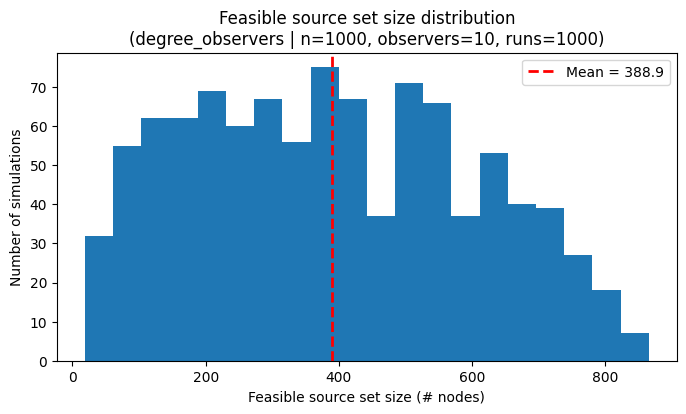

In [203]:
list_of_rngs = make_sim_rngs(master_seed=123, n_sims=1000)
degree_results = run_experiment(
    degree_observers,
    num_runs=1000,
    n_nodes=1000,
    n_observers=10,
    sim_rngs=list_of_rngs,
)


# High Betweenness Centrality Observers

Observer strategy: Highest-betweenness nodes
Runs: 1000 | Tree size: 1000 | Observers: 10
Feasible source set size (# nodes remaining after reduction):
  Mean ± Std: 346.65 ± 141.54
  Range:      3 to 652


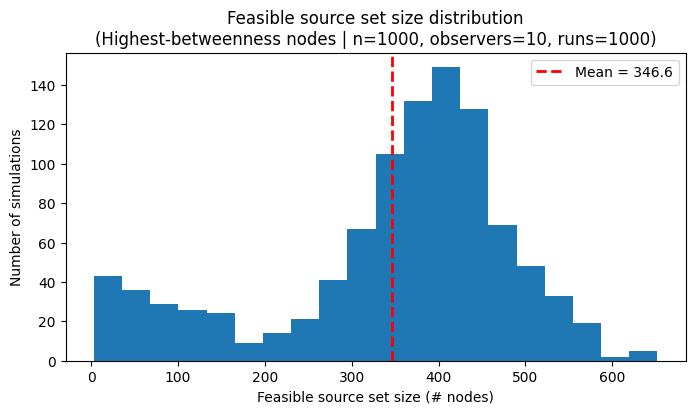

In [205]:
list_of_rngs = make_sim_rngs(master_seed=123, n_sims=1000)
betweenness_results = run_experiment(
    betweenness_observers,
    label="Highest-betweenness nodes",
    num_runs=1000,
    n_nodes=1000,
    n_observers=10,
    sim_rngs=list_of_rngs,
)

# Random Observers

Observer strategy: Random nodes
Runs: 1000 | Tree size: 1000 | Observers: 10
Feasible source set size (# nodes remaining after reduction):
  Mean ± Std: 794.94 ± 224.34
  Range:      5 to 998


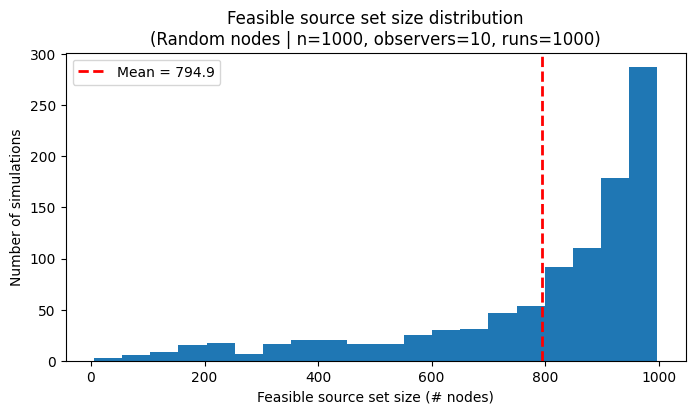

In [204]:
list_of_rngs = make_sim_rngs(master_seed=123, n_sims=1000)
random_results = run_experiment(
    random_observers,
    label="Random nodes",
    num_runs=1000,
    n_nodes=1000,
    n_observers=10,
    sim_rngs=list_of_rngs,
)

## Summary

This experiment demonstrates that observer placement informed by network structure can substantially improve source localization on trees.

In particular, strategies based on centrality measures consistently reduce the feasible source set more effectively than random placement, highlighting the value of structural awareness in partially observed networks.
